In [25]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import utils as ut
import LIM_class
plt.style.use("../plotting.mplstyle")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
data = xr.open_dataset("./data/ssta_1950_2021.nc")['ssta']

print("Data shape: {}".format(data.shape))
print("Data : {}".format(data))

Data shape: (864, 13, 35)
Data : <xarray.DataArray 'ssta' (time: 864, lat: 13, lon: 35)>
[393120 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-12-01
  * lat      (lat) float64 -30.0 -25.0 -20.0 -15.0 -10.0 ... 15.0 20.0 25.0 30.0
  * lon      (lon) float64 -60.0 -55.0 -50.0 -45.0 ... 95.0 100.0 105.0 110.0
    month    (time) int64 ...


In [27]:
# Use Principal Component Analysis to reduce the dimensionality of the data

pca_5 = ut.SpatioTemporalPCA(data, n_components=5)
pca_10 = ut.SpatioTemporalPCA(data, n_components=10)
pca_15 = ut.SpatioTemporalPCA(data, n_components=15)

eof_5 = pca_5.eofs()
eof_10 = pca_10.eofs()
eof_15 = pca_15.eofs()

pc_5 = pca_5.principal_components()
pc_10 = pca_10.principal_components()
pc_15 = pca_15.principal_components()


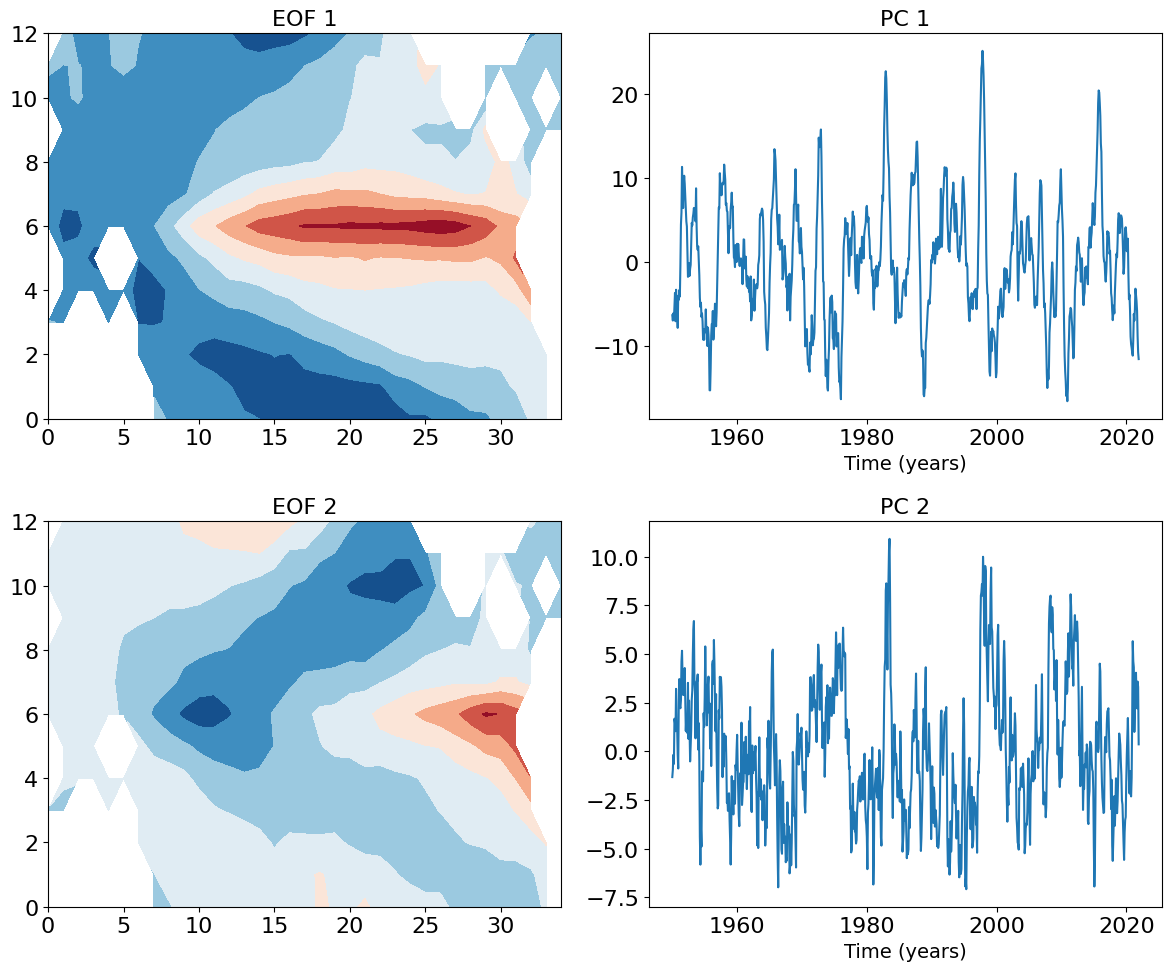

In [28]:
# Set the number of plots to 2
number_of_plots = 2

# Create the figure and axes objects
fig, axs = plt.subplots(number_of_plots, 2, figsize=(12, 10))

# Set titles and plot the contourf and plot for each EOF and PC
for i in range(number_of_plots):
    axs[i,0].set_title("EOF {}".format(i + 1), fontsize=16)
    axs[i,0].contourf(eof_10[i], cmap="RdBu_r")
    axs[i,1].set_title("PC {}".format(i + 1), fontsize=16)
    # Define time variable
    time = np.arange(len(pc_10[i]))
    # Convert time to years
    time_years = time/12 + 1950
    # Plot PC with time on x-axis in years
    axs[i,1].plot(time_years, pc_10[i])
    axs[i,1].set_xlabel("Time (years)", fontsize=14)

# Add padding between subplots and adjust layout
fig.tight_layout(pad=2)

In [29]:
# Create training and test data

data = pca_10.principal_components()
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]
data_test = data[:, index_train:]

In [30]:
# Creating an example LIM object

tau = 1
model = LIM_class.LIM(tau)
model.fit(data_train.data)
print("Data train : {} + shape: {}".format(type(data_train.data), data_train.data.shape))

Frobenius norm: 0.7288012156166609
Data train : <class 'numpy.ndarray'> + shape: (10, 691)


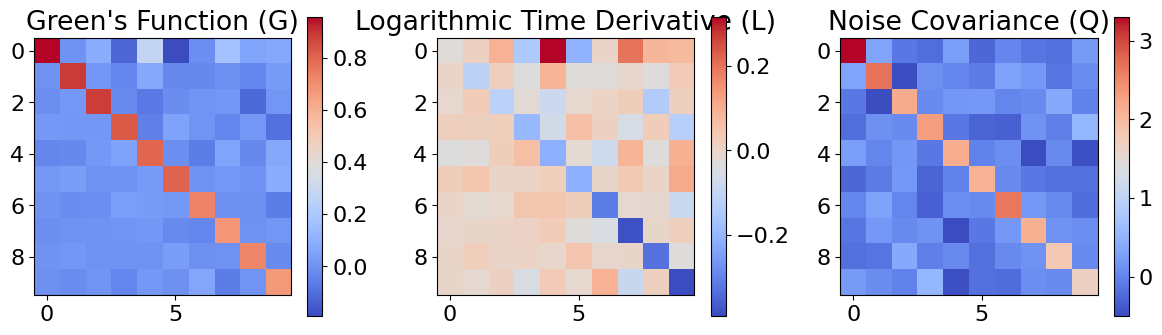

In [31]:
# Plot G, L, Q
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))

# Plot G
im1 = axs[0].imshow(model.green_function, cmap='coolwarm')
axs[0].set_title('Green\'s Function (G)')
fig.colorbar(im1, ax=axs[0])

# Plot L
im2 = axs[1].imshow(np.real(model.logarithmic_matrix), cmap='coolwarm')
axs[1].set_title('Logarithmic Time Derivative (L)')
fig.colorbar(im2, ax=axs[1])

# Plot Q
im3 = axs[2].imshow(np.real(model.noise_covariance), cmap='coolwarm')
axs[2].set_title('Noise Covariance (Q)')
fig.colorbar(im3, ax=axs[2])

plt.tight_layout()
plt.show()

In [32]:
# Model geometric brownian motion

#model.geometric_brownian_motion(mu=2)

In [33]:
# Simulate stochastic differential equation

x_input = data_test.isel(time=0)
#x_input = data_test.isel(time=np.arange(0,10))
times = x_input['time']
x = x_input.data

#forecast_output, forecast_output2 = model.forecast(x, [1,2,3])
output_array = model.noise_integration(x, timesteps=49)
print("Prediction-Array : {} + shape : {}".format(type(output_array), output_array.shape))


Prediction-Array : <class 'numpy.ndarray'> + shape : (50, 10)


Text(0.5, 1.0, 'Forecast')

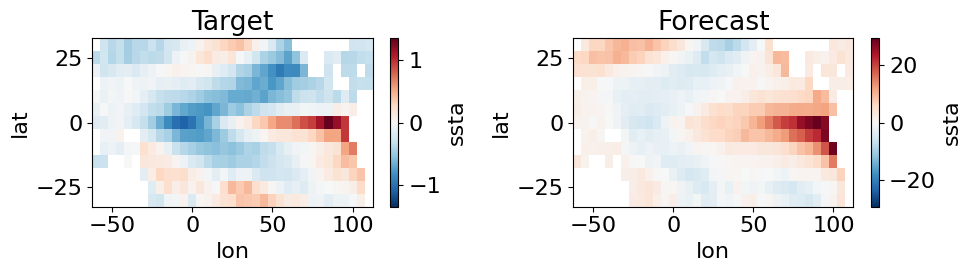

In [34]:
# Transform back to data space (denoted with y) and plot the time evolution of selected components

lag = 1

# Choose a time index to plot
time_index = 10

x_input = data_test.isel(time=np.arange(0,50))
times = x_input['time']
x = x_input.data
prediction_array = output_array.T

#print("X : {} + shape : {}".format(x, x.shape))
#print("Output_array : {} + shape : {}".format(output_array, output_array.shape))

# Reconstruct the input and forecasted data
reconstructed_input = pca_10.reconstruction(x[:, lag:], newdim=times[lag:])
reconstructed_forecast = pca_10.reconstruction(prediction_array[:, :-lag], newdim=times[lag:])

#print("Reconstructed_input : {} + shape : {}".format(type(reconstructed_input), reconstructed_input.shape))
#print("Reconstructed_forecast : {} + shape : {}".format(type(reconstructed_forecast), reconstructed_forecast.shape))

# Define plot parameters
plot_params = {'tsa': dict(vmin=-2, vmax=2, eps=0.25),
               'zosa': dict(vmin=-0.1, vmax=.1, eps=0.025)}

# Plot the input and forecasted data at the chosen time index
fig, axs = plt.subplots(1,2, figsize=(10, 3))
reconstructed_input.isel(time=time_index).plot(ax=axs[0])
axs[0].set_title("Target")
reconstructed_forecast.isel(time=time_index).plot(ax=axs[1])
axs[1].set_title("Forecast")

Performing LIM forecast for tau values: [1, 2, 3]
Forecast output : <class 'numpy.ndarray'> + shape: (10, 50)
Forecast2 output : <class 'numpy.ndarray'> + shape: (10, 50)


Text(0.5, 1.0, 'Forecast2')

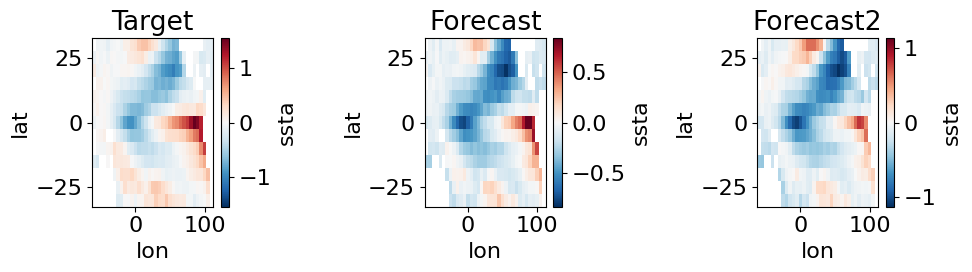

In [35]:
lag = 2
time_index = 10

x_input = data_test.isel(time=np.arange(0,50))
times = x_input['time']
x = x_input.data

#forecast_output = model.forecast_mean(x, lag=lag)
forecast_output, forecast_output2 = model.forecast(x, [1,2,3])

forecast_output = forecast_output[lag, : , :]
forecast_output2 = forecast_output2[lag, : , :]

print("Forecast output : {} + shape: {}".format(type(forecast_output), forecast_output.shape))
print("Forecast2 output : {} + shape: {}".format(type(forecast_output2), forecast_output2.shape))

# Reconstruct the input and forecasted data
reconstructed_input = pca_10.reconstruction(x[:, lag:], newdim=times[lag:])
reconstructed_forecast = pca_10.reconstruction(forecast_output[:, :-lag], newdim=times[lag:])
reconstructed_forecast2 = pca_10.reconstruction(forecast_output2[:, :-lag], newdim=times[lag:])

# Define plot parameters
plot_params = {'tsa': dict(vmin=-2, vmax=2, eps=0.25),
               'zosa': dict(vmin=-0.1, vmax=.1, eps=0.025)}

# Plot the input and forecasted data at the chosen time index
fig, axs = plt.subplots(1,3, figsize=(10, 3))
reconstructed_input.isel(time=time_index).plot(ax=axs[0])
axs[0].set_title("Target")
reconstructed_forecast.isel(time=time_index).plot(ax=axs[1])
axs[1].set_title("Forecast")
reconstructed_forecast2.isel(time=time_index).plot(ax=axs[2])
axs[2].set_title("Forecast2")


Performing LIM forecast for tau values: [1, 2, 3]
X_frcst : <class 'numpy.ndarray'> + shape : (10, 50)
X : <class 'numpy.ndarray'> + shape : (10, 50)


Text(0.5, 0, 'Time')

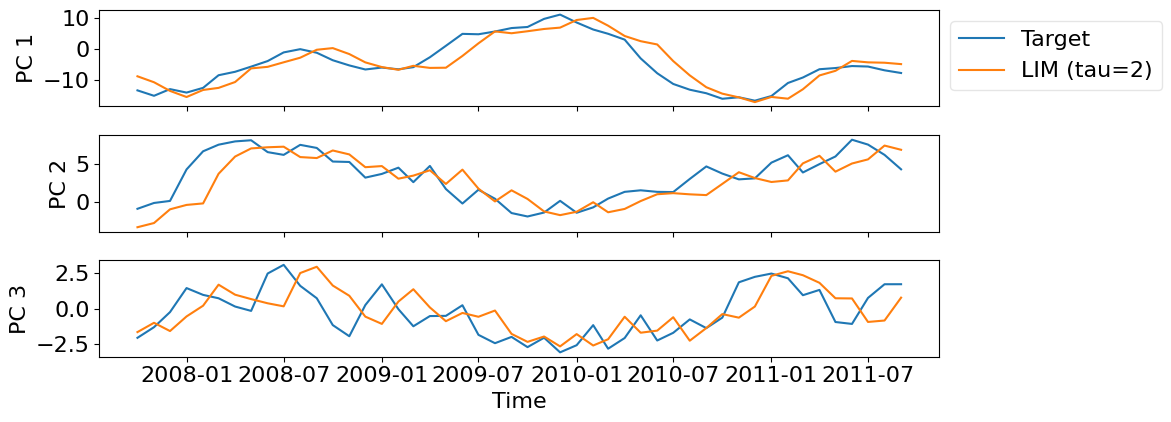

In [36]:
# Forecasting

# Define lag
lag = 2

# Get input data
x_target = data_test.isel(time=np.arange(0, 50))
times = x_target['time']
x = x_target.data

#forecast_output = model.forecast_mean(x, lag=lag)
forecast_output, forecast_output2 = model.forecast(x, [1,2,3])

forecast_output = forecast_output[lag, : , :]
forecast_output2 = forecast_output2[lag, : , :]

# Get input data
x_input = data_test.isel(time=0)
x_input = x_input.data

# Forecast mean using LIM model
output_array = model.noise_integration(x_input, timesteps=49)
output_array = output_array.T
#output_array = forecast_output2

# Plot time evolution of selected components
idx_components = [0, 1, 2]
fig, axs = plt.subplots(len(idx_components), figsize=(12, len(idx_components)*1.5), sharex=True)

print("X_frcst : {} + shape : {}".format(type(output_array), output_array.shape))
print("X : {} + shape : {}".format(type(x), x.shape))

for i, component in enumerate(idx_components):
    # Plot target data for the component
    axs[i].plot(times[lag:], x[component, lag:], label='Target')

    # Plot forecasted data using LIM model
    axs[i].plot(times[lag:], output_array[component, :-lag], label=f'LIM (tau={lag})')

    # Set y-axis label
    axs[i].set_ylabel(f'PC {component+1}')

# Add legend
_ = axs[0].legend(bbox_to_anchor=(1, 1), loc="upper left")

# Set x-axis label for the last subplot
axs[-1].set_xlabel('Time')